In [ ]:
# imports
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torch
import torchvision
import pandas as pd
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from resnet_pytorch import ResNet 

from PIL import Image
# import PIL.Image
import os
import glob
import numpy as np
import cv2 as cv
import io
from IPython.display import clear_output, display
from tqdm import tqdm

import matplotlib.pyplot as plt
import warnings
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import classification_report

warnings.filterwarnings('ignore')

In [ ]:
### global stuff
# DATA_FOLDER:
# contains data_labels.txt, with_rips folder images and without_rips folder images
DATA_FOLDER = "./training_data" 
images_rip = glob.glob(os.path.join(DATA_FOLDER, "with_rips/*.png")) 
images_norip = glob.glob(os.path.join(DATA_FOLDER, "without_rips/*.png")) 

In [ ]:
def data_load_preprocess_split(DATA_FOLDER, split_size = 0.2):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    data = datasets.ImageFolder(DATA_FOLDER, transform = preprocess)
    
    data_size = len(data)
    idxs = list(range(data_size))
    
    split = int(np.floor(split_size * data_size))
    
    np.random.shuffle(idxs)
    
    train_idx, validation_idx, test_idx = idxs[split*2:], idxs[split:split*2], idxs[:split]
    
    train_sampler = SubsetRandomSampler(train_idx)
    validation_sampler = SubsetRandomSampler(validation_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    train_loader = torch.utils.data.DataLoader(data, sampler = train_sampler, batch_size=128, num_workers=8)
    validation_loader = torch.utils.data.DataLoader(data, sampler = validation_sampler, batch_size=256, num_workers=8)
    test_loader = torch.utils.data.DataLoader(data, sampler = test_sampler, batch_size=256, num_workers=8)
    
    return train_loader, validation_loader, test_loader

train_loader, validation_loader, test_loader = data_load_preprocess_split(DATA_FOLDER, 0.2)

print(train_loader.dataset.classes)

['with_rips', 'without_rips']


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")

In [ ]:
input_dim = 224 * 224 * 3
output_dim = 2
batch_size = 64

model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, 1024),
    torch.nn.BatchNorm1d(1024),
    torch.nn.Dropout(p=0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 512),
    torch.nn.BatchNorm1d(512),
    torch.nn.Dropout(p=0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.BatchNorm1d(256),
    torch.nn.Dropout(p=0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.BatchNorm1d(128),
    torch.nn.Dropout(p=0.5),
    torch.nn.ReLU(),
    torch.nn.Linear(128, 2)
)

# model = torch.nn.Sequential(
#     torch.nn.Linear(input_dim, 512),
#     torch.nn.ReLU(),
#     torch.nn.Linear(512, 2)
# )

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr= 0.003)

# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model = model.to(device)


In [ ]:
device

device(type='cuda')

In [ ]:
epochs = 25 

train_losses, validation_losses = [], []

train_accuracies, validation_accuracies = [], []

# early stopping
epochs_limit = 6
epochs_without_improvement = 0
min_validation_loss = np.Inf

for epoch in range(epochs):
    train_loss = 0.0
    validation_loss = 0.0
    
    train_accuracy = 0
    validation_accuracy = 0
    
    total_validation = 0
    total_train = 0
    
    for inputs, labels in tqdm(train_loader, desc='Train'):
        optimizer.zero_grad()
        
        d1, d2, d3, d4 = inputs.shape # (64, 3, 244, 244 )
        inputs = inputs.reshape((d1, d3 * d2 * d4)) # (64, 224, 672)
#         labels = labels.reshape((labels.shape[0], 1))
        inputs, labels = inputs.to(device), labels.to(device)
        
        prediction = model(inputs)
        
        loss = criterion(prediction, labels)
        
        loss.backward()
        
        optimizer.step()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.zero_grad()
        
        train_loss += loss.item()
        
        total_train += labels.shape[0]
        train_accuracy += (prediction.argmax(dim=1) == labels).sum().item()
        
    train_losses.append(train_loss)
    train_accuracies.append(100 * train_accuracy / total_train)

    model.eval()  
    
    with torch.no_grad():
        for inputs, labels in tqdm(validation_loader, desc='Validation'):            
            d1, d2, d3, d4 = inputs.shape
            inputs = inputs.reshape((d1, d3 * d2 *d4))
#             labels = labels.reshape((labels.shape[0], 1))
            
            inputs, labels = inputs.to(device), labels.to(device)

            prediction = model(inputs)

            loss = criterion(prediction, labels)

            validation_loss += loss.item()
            total_validation += labels.shape[0]
            validation_accuracy += (prediction.argmax(dim=1) == labels).sum().item()
            
    validation_losses.append(validation_loss)
    validation_accuracies.append(100 * validation_accuracy / total_validation)
        
    if (validation_loss < min_validation_loss):
        epochs_without_improvement = 0
        min_validation_loss = validation_loss
    elif (epoch > 5):
        epochs_without_improvement += 1
        print(epochs_without_improvement)

    if (epoch > 5 and epochs_without_improvement >= epochs_limit):
        print("Early stopping")
        print(f'Epoch {epoch + 1}')
        print("Stopping model training.")
        break;
    else:
        torch.save(model, 'rip-fully-connected.pth')
    
    print(f'Epoch {epoch + 1}')
    print(f'Training Loss: {train_loss / len(train_loader)}\t Train Accuracy: {100 * train_accuracy / total_train}')
    print(f'Validation Loss: {validation_loss / len(validation_loader)} \t Validation Accuracy: {100 * validation_accuracy / total_validation}')

Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 1
Training Loss: 0.5881272628903389	 Train Accuracy: 70.73825503355705
Validation Loss: 0.7559718489646912 	 Validation Accuracy: 70.36290322580645


Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 2
Training Loss: 0.5881302853425344	 Train Accuracy: 75.97315436241611
Validation Loss: 0.5298258662223816 	 Validation Accuracy: 77.41935483870968


Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 3
Training Loss: 0.4266730646292369	 Train Accuracy: 80.33557046979865
Validation Loss: 0.492795392870903 	 Validation Accuracy: 78.4274193548387


Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 4
Training Loss: 0.37507328018546104	 Train Accuracy: 82.95302013422818
Validation Loss: 0.47244349122047424 	 Validation Accuracy: 81.25


Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 5
Training Loss: 0.33622120320796967	 Train Accuracy: 85.30201342281879
Validation Loss: 0.35578083992004395 	 Validation Accuracy: 84.0725806451613


Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 6
Training Loss: 0.2891825499633948	 Train Accuracy: 88.32214765100672
Validation Loss: 0.39814238250255585 	 Validation Accuracy: 81.85483870967742


Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 7
Training Loss: 0.27624039972821873	 Train Accuracy: 88.18791946308725
Validation Loss: 0.3202604204416275 	 Validation Accuracy: 86.29032258064517


Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 8
Training Loss: 0.2480366863310337	 Train Accuracy: 90.33557046979865
Validation Loss: 0.2985839396715164 	 Validation Accuracy: 86.69354838709677


Validation: 100%|██████████| 2/2 [00:12<00:00,  6.10s/it]


1


Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 9
Training Loss: 0.20600801395873228	 Train Accuracy: 91.34228187919463
Validation Loss: 0.4778591990470886 	 Validation Accuracy: 85.28225806451613


Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 10
Training Loss: 0.19096236179272333	 Train Accuracy: 92.3489932885906
Validation Loss: 0.2938603460788727 	 Validation Accuracy: 87.5


Validation: 100%|██████████| 2/2 [00:13<00:00,  6.67s/it]


1


Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 11
Training Loss: 0.1420678086578846	 Train Accuracy: 94.56375838926175
Validation Loss: 0.36891208589076996 	 Validation Accuracy: 88.30645161290323


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.48s/it]


2


Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 12
Training Loss: 0.1254614870995283	 Train Accuracy: 94.56375838926175
Validation Loss: 0.4121399372816086 	 Validation Accuracy: 86.69354838709677


Validation: 100%|██████████| 2/2 [00:12<00:00,  6.20s/it]


3


Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 13
Training Loss: 0.09964318759739399	 Train Accuracy: 95.90604026845638
Validation Loss: 0.418175145983696 	 Validation Accuracy: 86.49193548387096


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.40s/it]


4


Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 14
Training Loss: 0.07403707442184289	 Train Accuracy: 97.04697986577182
Validation Loss: 0.32620100677013397 	 Validation Accuracy: 90.3225806451613


Validation: 100%|██████████| 2/2 [00:12<00:00,  6.38s/it]


5


Train:   0%|          | 0/12 [00:00<?, ?it/s]

Epoch 15
Training Loss: 0.0733244811805586	 Train Accuracy: 97.31543624161074
Validation Loss: 0.42467252910137177 	 Validation Accuracy: 88.30645161290323


Validation: 100%|██████████| 2/2 [00:10<00:00,  5.23s/it]

6
Early stopping
Epoch 16
Stopping model training.


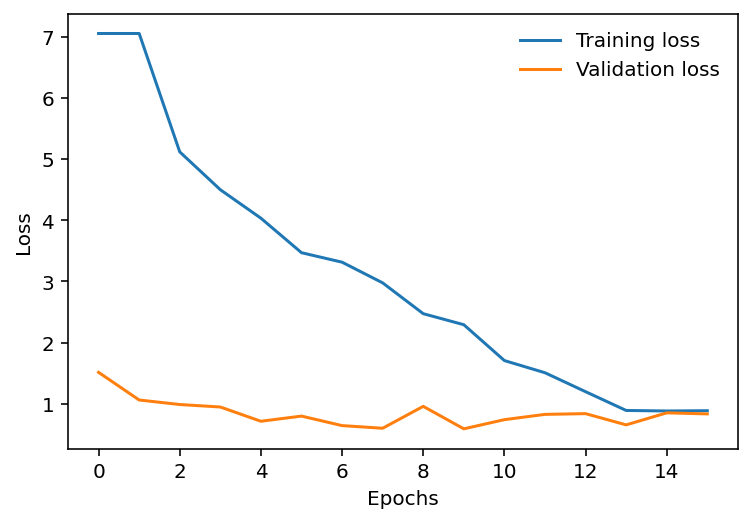

In [ ]:
plt.plot(train_losses, label = 'Training loss')
plt.plot(validation_losses, label = 'Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)
plt.show()

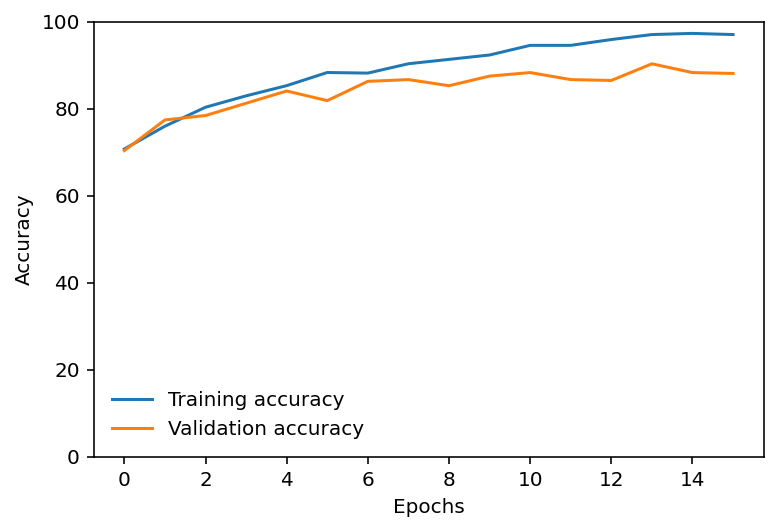

In [ ]:
plt.ylim(0, 100)
plt.plot(train_accuracies, label = 'Training accuracy')
plt.plot(validation_accuracies, label = 'Validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(frameon=False)
plt.show()

In [ ]:
model = torch.load('rip-fully-connected.pth')

test_accuracy = 0    
total_test = 0

model.eval()  

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Test'):
        d1, d2, d3, d4 = inputs.shape
        inputs = inputs.reshape((d1, d3 * d2 *d4))
        labels = labels.reshape((labels.shape[0], 1))
        
        inputs, labels = inputs.to(device), labels.to(device)

        prediction = model(inputs)
        
        all_labels.append(labels.cpu().numpy())
        
        predictions = prediction.argmax(dim=1)
        
        all_predictions.append(predictions.cpu().numpy())
#         loss = criterion(prediction, labels)

#     total_test = labels.size(0)
#     test_accuracy = (prediction.argmax(dim=1) == labels).sum().item()
    
# lista de numpy arrays -> only one list



Test: 100%|██████████| 2/2 [00:31<00:00, 15.76s/it]


In [ ]:
all_labels = np.concatenate(all_labels,axis=0)
all_predictions = np.concatenate(all_predictions, axis=0)

In [ ]:
clf_rep  = classification_report(all_labels, all_predictions)
print(clf_rep)

              precision    recall  f1-score   support

           0       0.93      0.92      0.92       364
           1       0.78      0.80      0.79       132

    accuracy                           0.89       496
   macro avg       0.85      0.86      0.86       496
weighted avg       0.89      0.89      0.89       496

